### Planning

- Brief analysis of each of the dataframes.
- Merge the 4 dataframes using customer_id as the base.
- Perform EDA on this dataframe.
    - Clean the data and remove inconsistencies.
    - Visualize the data and understand the variables.
    - Identify patterns of customers who suffer from churn.
- Perform feature engineering.
- Split the data into training and testing.
    - Transform the Yes or No columns into binary columns of 1 and 0.
    - Perform encoding of the categorical variables.
- Use AUC-ROC metric.
    - Great metric for churn problems.
- Train several classification models on the validation set.
    - Create pipelines of the models.
    - Perform Cross-Validation
    - Plot ROC curve and confusion matrix for the models.
    - Evaluate the model based on the AUC-ROC metric.
- Choose the best models to proceed.
    - Perform hyperparameter tuning on these models. 
    - Train the best models on the test set.
- Analyze the best model extensively.


### Importing Libraries

In [96]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import category_encoders as ce

# Importing plot libs
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
sns.set_style('darkgrid')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pal = sns.color_palette('rainbow')
pal.as_hex()

['#386df9', '#12c8e6', '#5af8c8', '#a4f89f', '#ecc86f', '#ff6d38']

In [98]:
str(pal.as_hex())

"['#386df9', '#12c8e6', '#5af8c8', '#a4f89f', '#ecc86f', '#ff6d38']"

### Reading Datasets

In [99]:
df_contract = pd.read_csv('datasets/contract.csv')
df_internet = pd.read_csv('datasets/internet.csv')
df_personal = pd.read_csv('datasets/personal.csv')
df_phone = pd.read_csv('datasets/phone.csv')

### Contract

In [100]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [101]:
df_contract.shape

(7043, 8)

In [102]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [103]:
df_contract.duplicated().sum()

0

In [104]:
df_contract['EndDate'].value_counts()

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [105]:
df_contract['TotalCharges'].value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

In [106]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(' ', 0)

In [107]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float64')

### Internet

In [108]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [109]:
df_internet.shape

(5517, 8)

In [110]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [111]:
df_internet.duplicated().sum()

0

In [112]:
df_internet['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

### Personal

In [113]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [114]:
df_personal.shape

(7043, 5)

In [115]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [116]:
df_personal.duplicated().sum()

0

### Phone

In [117]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [118]:
df_phone.shape

(6361, 2)

In [119]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [120]:
df_phone.duplicated().sum()

0

In [121]:
df_phone['MultipleLines'].value_counts()

MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64

### Merge

In [122]:
merged_1 = pd.merge(df_contract, df_personal, on='customerID', how='outer')

In [123]:
merged_2 = pd.merge(merged_1, df_internet, on='customerID', how='outer')

In [124]:
df = pd.merge(merged_2, df_phone, on='customerID', how='outer')

In [125]:
df = df.sort_values(by="TotalCharges", ascending=False)

### EDA

In [126]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2003,2889-FPWRM,2013-10-01,2019-10-01 00:00:00,One year,Yes,Bank transfer (automatic),117.80,8684.80,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5360,7569-NMZYQ,2014-02-01,No,Two year,Yes,Bank transfer (automatic),118.75,8672.45,Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6855,9739-JLPQJ,2014-02-01,No,Two year,No,Credit card (automatic),117.50,8670.10,Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6892,9788-HNGUT,2014-02-01,No,Two year,Yes,Credit card (automatic),116.95,8594.40,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6275,8879-XUAHX,2014-03-01,No,Two year,Yes,Electronic check,116.25,8564.75,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [127]:
df.shape

(7043, 20)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 2003 to 1731
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 
 1

In [129]:
# Renaming columns to snake_case
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()
df.rename(columns={'customer_i_d': 'customer_id', 'streaming_t_v': 'streaming_tv'}, inplace=True)

In [130]:
# Checking for duplicates in dataframe after merge
df.duplicated().sum()

0

In [131]:
# Checking missing values ​​in dataframe after merge
(df
 .isna()
 .sum()
 .sort_values(ascending=False)
 .reset_index()
 .rename(columns = {'index' : "Column", 0 : "Missing"})
)

,Column,Missing
0,streaming_movies,1526
1,streaming_tv,1526
2,tech_support,1526
3,device_protection,1526
4,online_backup,1526
5,online_security,1526
6,internet_service,1526
7,multiple_lines,682
8,begin_date,0
9,dependents,0


In [132]:
# The missing values ​​found are from services whose client had no data before the merge, so we can fill in with "No".
df.fillna('No', inplace=True)

In [133]:
# Creating a "churn" column with 0 and 1 for binary classification
df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [134]:
df['churn'].value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

We noticed a churn rate of 26%

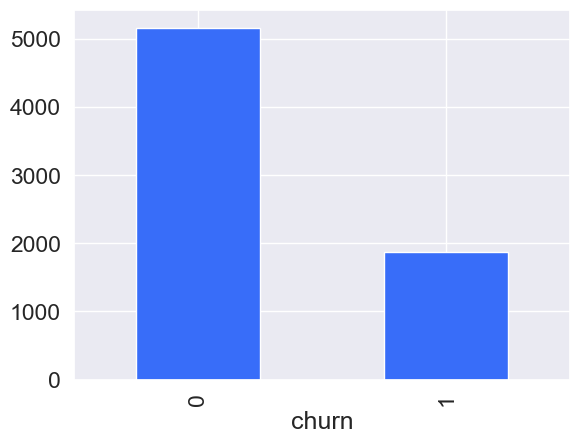

In [135]:
df['churn'].value_counts().plot(kind='bar');

In [136]:
df[df['churn'] == 1]['type'].value_counts()

type
Month-to-month    1655
One year           166
Two year            48
Name: count, dtype: int64

Most users who suffer from churn use monthly subscriptions.

In [137]:
numeric_cols = ['monthly_charges', 'total_charges']
df.groupby(['churn'])[numeric_cols].describe(percentiles=[])

monthly_charges                                               \
                count       mean        std    min     50%     max   
churn                                                                
0              5174.0  61.265124  31.092648  18.25  64.425  118.75   
1              1869.0  74.441332  24.666053  18.85  79.650  118.35   

      total_charges                                                      
              count         mean          std    min       50%      max  
churn                                                                    
0            5174.0  2549.911442  2329.954215   0.00  1679.525  8672.45  
1            1869.0  1531.796094  1890.822994  18.85   703.550  8684.80

Users who suffer churn have a slightly higher average monthly charges than those who do not suffer churn, which is reversed in total charges.

In [138]:
pd.crosstab(df['churn'], df['internet_service'], normalize=True)

internet_service,DSL,Fiber optic,No
churn,,,
0,0.278574,0.255431,0.200625
1,0.065171,0.184154,0.016044


In [139]:
churn_by_internet_service = df.groupby('internet_service')['churn'].mean().reset_index()
churn_by_internet_service

,internet_service,churn
0,DSL,0.189591
1,Fiber optic,0.418928
2,No,0.074050


Most of the churn comes from users with fiber optic internet service.

In [140]:
pd.crosstab(df['churn'], df['multiple_lines'], normalize=True)

multiple_lines,No,Yes
churn,,
0,0.433480,0.301150
1,0.144683,0.120687


In [141]:
churn_by_gender = df.groupby('gender')['churn'].mean().reset_index()
churn_by_gender

,gender,churn
0,Female,0.269209
1,Male,0.261603


In [142]:
services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for service in services:
    churn_by_service = df.groupby(service)['churn'].mean().reset_index()
    print(f'Churn rate by {service}:')
    print(churn_by_service)

Churn rate by online_security:
  online_security     churn
0              No  0.313296
1             Yes  0.146112
Churn rate by online_backup:
  online_backup     churn
0            No  0.291721
1           Yes  0.215315
Churn rate by device_protection:
  device_protection     churn
0                No  0.286518
1               Yes  0.225021
Churn rate by tech_support:
  tech_support     churn
0           No  0.311862
1          Yes  0.151663
Churn rate by streaming_tv:
  streaming_tv     churn
0           No  0.243312
1          Yes  0.300702
Churn rate by streaming_movies:
  streaming_movies     churn
0               No  0.243795
1              Yes  0.299414


Most users who experience churn do not have most of the extra services of internet, online security, backup, device protection and tech support. However, slightly more users have streaming services and still experience churn.


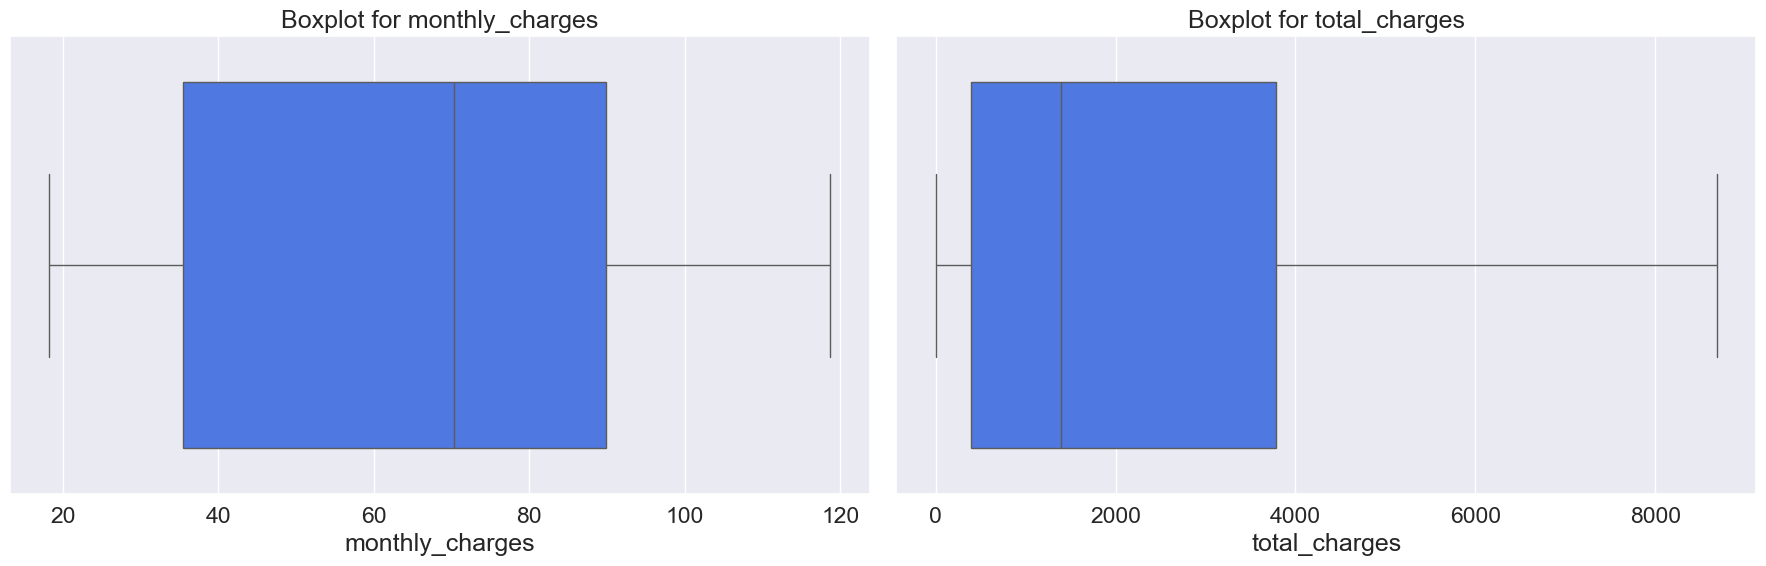

In [143]:
numeric_cols = ['monthly_charges', 'total_charges']
plt.figure(figsize=(18, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()

We do not see the presence of outliers.

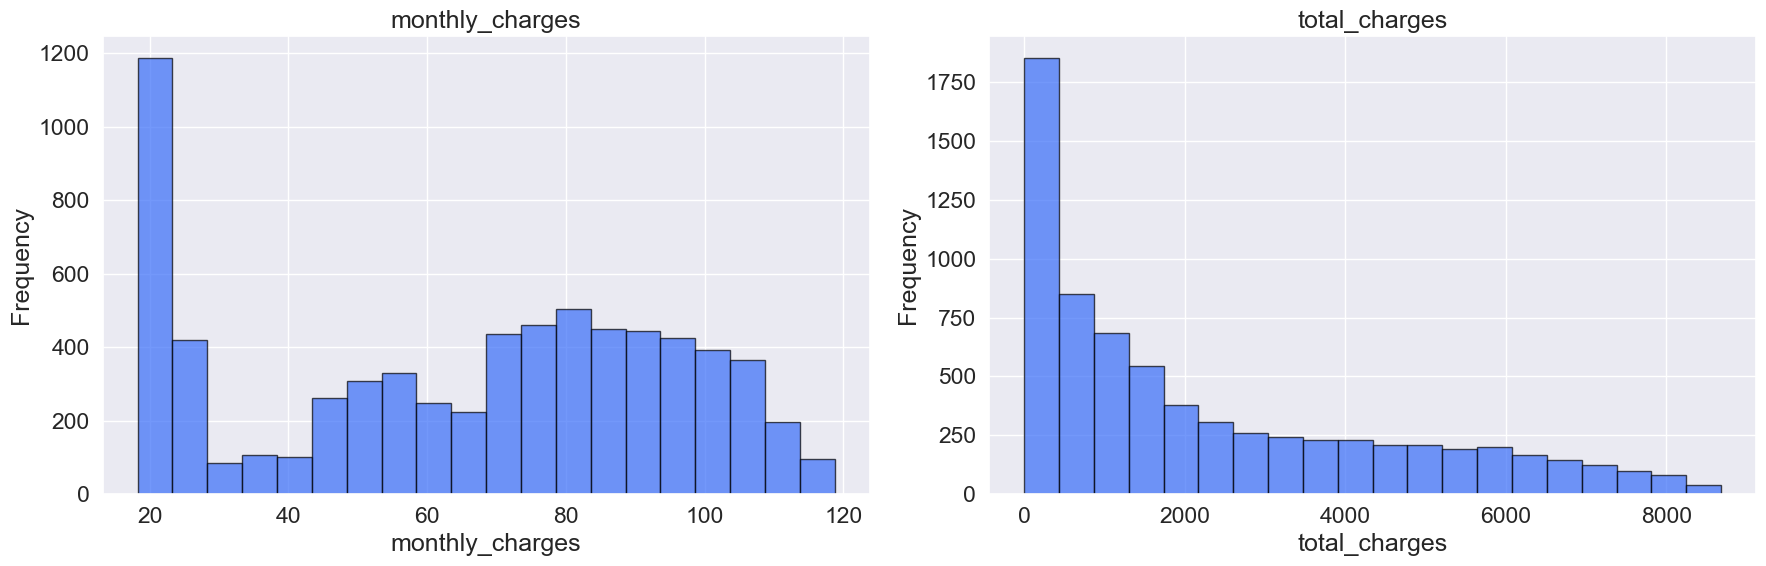

In [144]:
numeric_cols = ['monthly_charges', 'total_charges']
plt.figure(figsize=(18, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 2, i)
    plt.hist(df[col], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

In [145]:
df['monthly_charges_bucket'] = pd.cut(df['monthly_charges'], bins=5)
df['total_charges_bucket'] = pd.cut(df['total_charges'], bins=5)

monthly_charges_churn = df.groupby('monthly_charges_bucket')['churn'].mean()
total_charges_churn = df.groupby('total_charges_bucket')['churn'].mean()

print('Churn by Monthly Charges bucket:')
print(monthly_charges_churn)
print('\nChurn by Total Charges bucket:')
print(total_charges_churn)

Churn by Monthly Charges bucket:
monthly_charges_bucket
(18.15, 38.35]     0.114079
(38.35, 58.45]     0.269652
(58.45, 78.55]     0.294806
(78.55, 98.65]     0.369660
(98.65, 118.75]    0.300573
Name: churn, dtype: float64

Churn by Total Charges bucket:
total_charges_bucket
(-8.685, 1736.96]     0.328411
(1736.96, 3473.92]    0.245791
(3473.92, 5210.88]    0.167048
(5210.88, 6947.84]    0.147100
(6947.84, 8684.8]     0.106936
Name: churn, dtype: float64


We see that a large part of the churn comes from users with high monthly charges but low total charges. We can conclude that this occurs due to cancellation after a short subscription period.

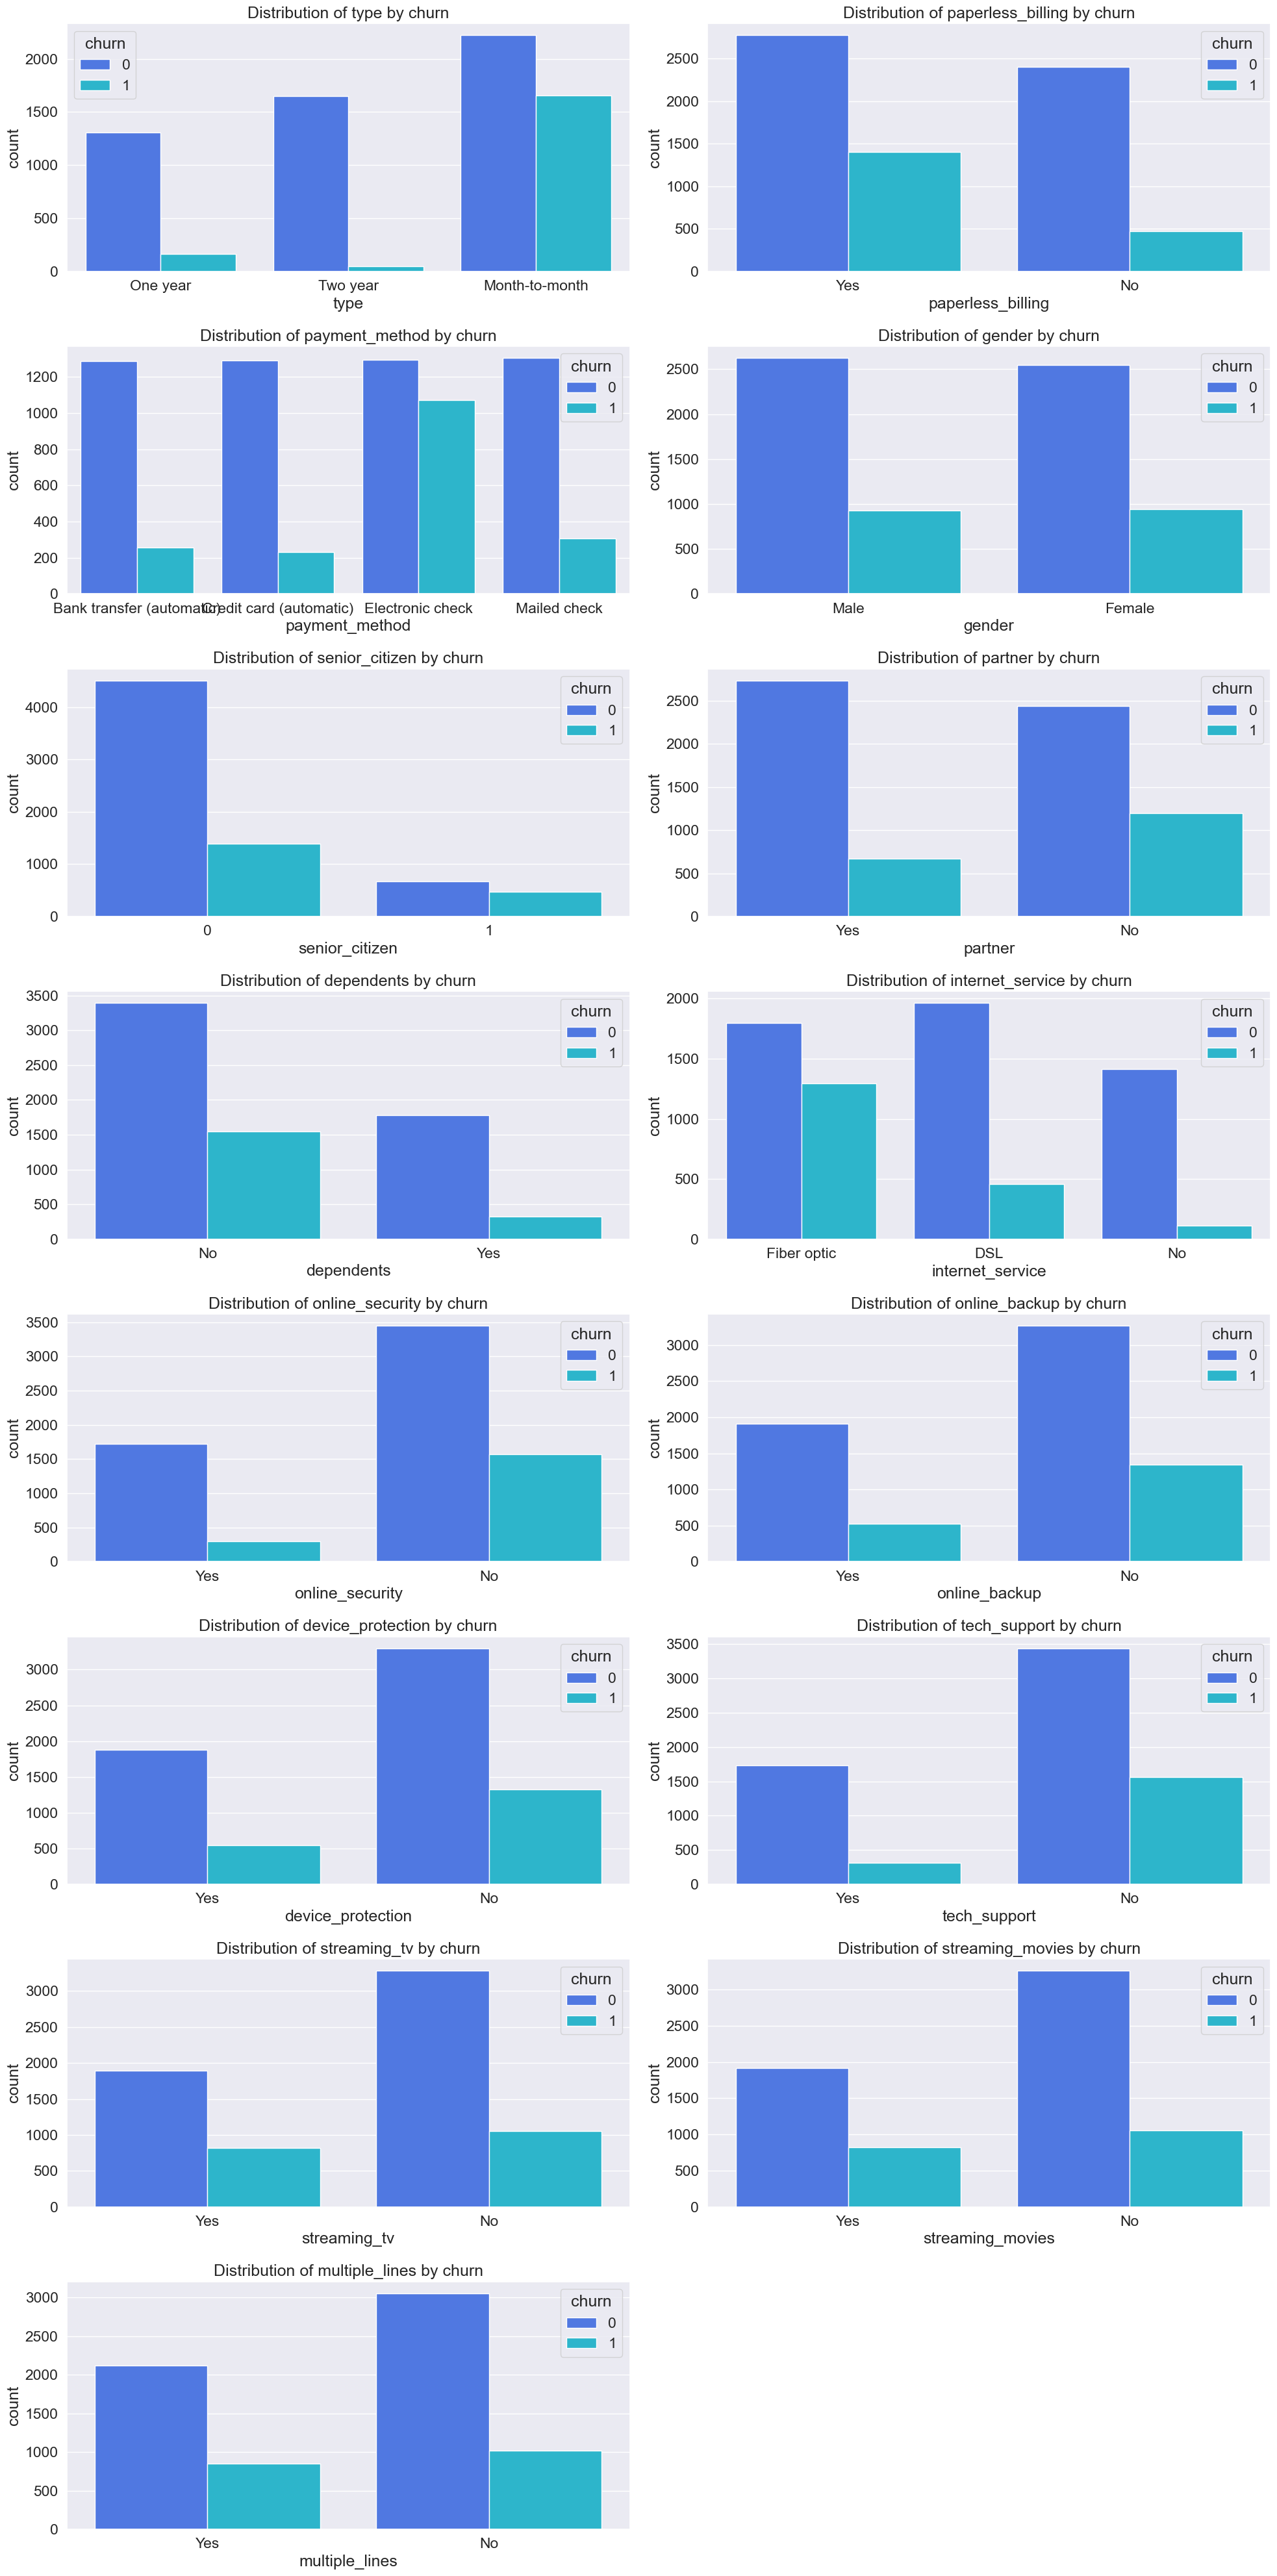

In [146]:
columns = [col for col in df.columns if col not in ['customer_id', 'begin_date', 'end_date', 'monthly_charges', 'total_charges', 'churn', 'monthly_charges_bucket', 'total_charges_bucket']]
n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols 
plt.figure(figsize=(20, n_rows * 5)) 
for i, column in enumerate(columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=column, hue='churn', data=df)
    plt.title(f'Distribution of {column} by churn')
    plt.tight_layout()


Analyzing this plot of categorical variables, we can notice some interesting data to try to understand the cause of the 26% churn percentage. We see that a large part of the users who suffer churn use the monthly plan (month-to-month), as well as using a non-automatic payment method (electronic check). We also see that many of these users do not have partners or dependents, and also do not have most of the internet benefits in their plan, such as: online security, online backup, device protection and tech support.

In [147]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
current_date = pd.to_datetime("today")
df['end_date'] = df['end_date'].fillna(current_date)
df['duration_years'] = (df['end_date'] - df['begin_date']).dt.days / 365

In [148]:
churn_by_duration = df.groupby(pd.cut(df['duration_years'], bins=10))['churn'].mean().reset_index()
churn_by_duration.columns = ['Duration (Years)', 'Churn Rate']

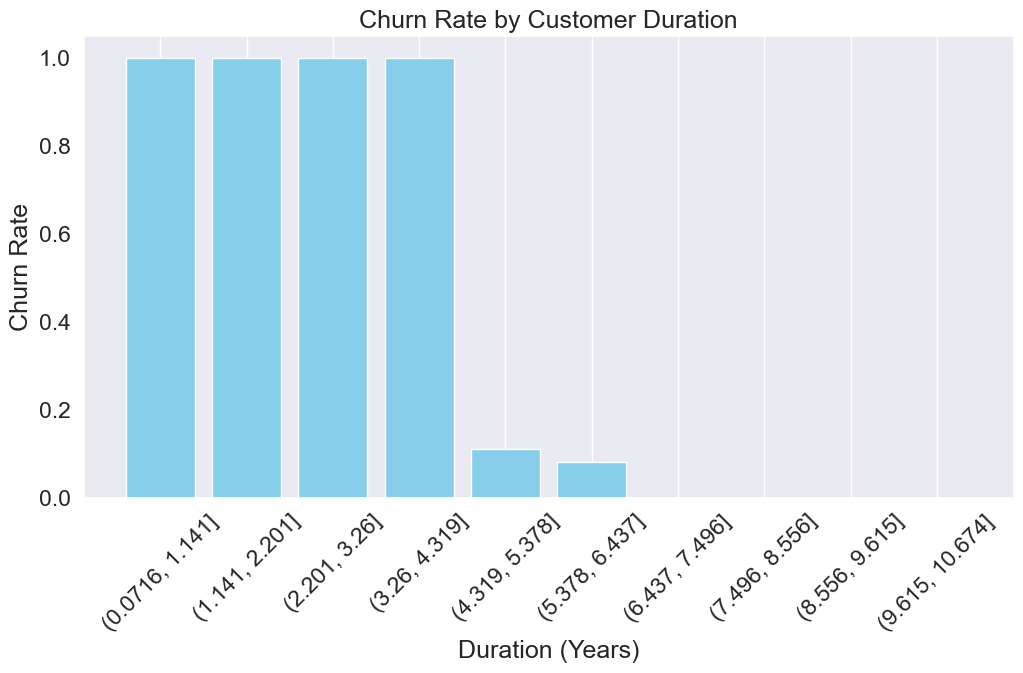

In [149]:
plt.figure(figsize=(12, 6))
plt.bar(churn_by_duration['Duration (Years)'].astype(str), churn_by_duration['Churn Rate'], color='skyblue')
plt.xlabel('Duration (Years)')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Customer Duration')
plt.xticks(rotation=45)
plt.grid(axis='y')

By analyzing the subscription time of customers who suffer churn, we can conclude a customer retention problem and note long-term loyalty.

### Conclusions

We currently have a churn rate of around 26%. During our EDA, after joining all 4 dataframes, cleaning the data and removing inconsistencies, we obtained a good understanding of the data, identified patterns and trends in the variables that may be the cause (or one of them) of this churn rate, and understood part of the behavior of customers who suffer from churn, such as: Monthly subscription, non-automatic payment, no partners or dependents, type of internet, few internet services. We identified temporal patterns, the length of stay of these customers is low. We did not find any anomalies in the data, our numeric variables do not have outliers, we corrected the begin and end date columns to the datetime type and we no longer have null or duplicate values.

In the next step, we will seek solutions to this churn problem using model training. Some ideas for feature engineering are a count of the services that the customer has, binary features to check if the customer uses digital payments, and features for the year, month, and day of the week in which the customer purchased the subscription. To address this problem, we need to deal with class imbalance, test different types of models to understand which one best deals with our problem, and then move on to hyperparameter tuning and model selection.

### Feature Engineering

In [150]:
# Transforming Yes or No columns into binary columns of 1 and 0.
binary_cols = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
for col in binary_cols: 
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [151]:
# Features to check the year, month and day of the week that the customer purchased the subscription.
df['begin_year'] = df['begin_date'].dt.year
df['begin_month'] = df['begin_date'].dt.month
df['begin_dow'] = df['begin_date'].dt.dayofweek

In [152]:
# Feature for counting services owned by the client.
df['services_count'] = df[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']].sum(axis=1)

In [153]:
# Binary feature indicating whether the customer uses a digital payment method.
df['is_digital_payment'] = df['payment_method'].apply(lambda x: 1 if x in ['Bank transfer (automatic)', 'Credit card (automatic)'] else 0)

### Train / Validation / Test

In [154]:
FEATURES = ['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 
            'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'services_count', 'is_digital_payment', 
            'begin_year', 'begin_month', 'begin_dow']
TARGET = ['churn']

CATEGORICAL_FEATURES = df[FEATURES].select_dtypes('object').columns

In [155]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [156]:
encoder = ce.CatBoostEncoder(cols=CATEGORICAL_FEATURES)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_train_val = encoder.transform(X_train_val)
X_test = encoder.transform(X_test)
X_val = encoder.transform(X_val)

### Evaluating Models

In [157]:
def create_pipeline(model, categorical_features):
    return Pipeline([
        ('encoder', ce.CatBoostEncoder(cols=categorical_features)), 
        ('scaler', StandardScaler()), 
        ('model', model)
    ])

In [158]:
def plot_roc_cm(model_name, y_val, y_pred_proba, y_pred):
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

    plt.tight_layout()

In [159]:
pos_weight = np.sum(y_train['churn'] == 0) / np.sum(y_train['churn'] == 1)

Model: Logistic_Regression
AUC-ROC (Cross-Validation): 0.835 ± 0.013
AUC-ROC (Validation Set): 0.830


Model: Decision_Tree
AUC-ROC (Cross-Validation): 0.712 ± 0.027
AUC-ROC (Validation Set): 0.728


Model: Random_Forest
AUC-ROC (Cross-Validation): 0.871 ± 0.016
AUC-ROC (Validation Set): 0.871


Model: SVC
AUC-ROC (Cross-Validation): 0.840 ± 0.015
AUC-ROC (Validation Set): 0.848


Model: KNN
AUC-ROC (Cross-Validation): 0.779 ± 0.026
AUC-ROC (Validation Set): 0.783


Model: Gradient_Boosting
AUC-ROC (Cross-Validation): 0.882 ± 0.021
AUC-ROC (Validation Set): 0.890


Model: Adaboost
AUC-ROC (Cross-Validation): 0.868 ± 0.019
AUC-ROC (Validation Set): 0.883


Model: LGBM
AUC-ROC (Cross-Validation): 0.897 ± 0.009
AUC-ROC (Validation Set): 0.906


Model: XGBoost
AUC-ROC (Cross-Validation): 0.899 ± 0.010
AUC-ROC (Validation Set): 0.908


Model: CatBoost
AUC-ROC (Cross-Validation): 0.897 ± 0.011
AUC-ROC (Validation Set): 0.906




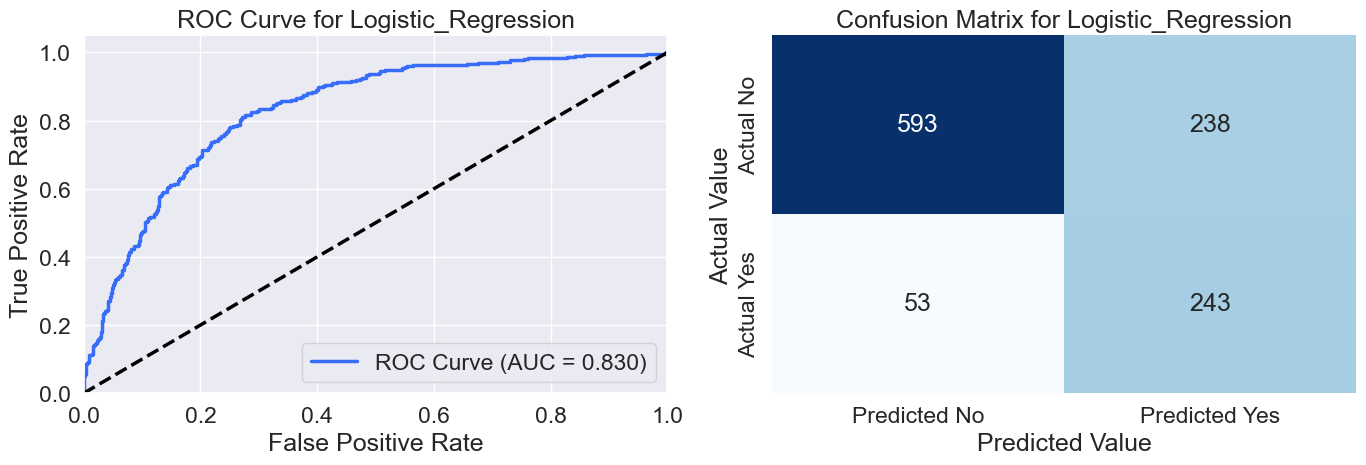

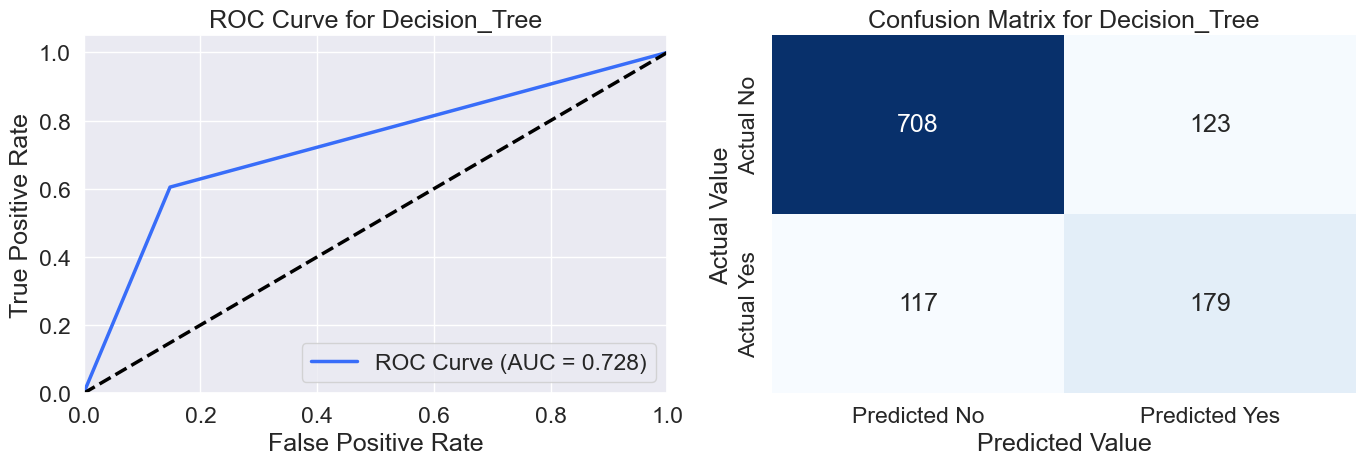

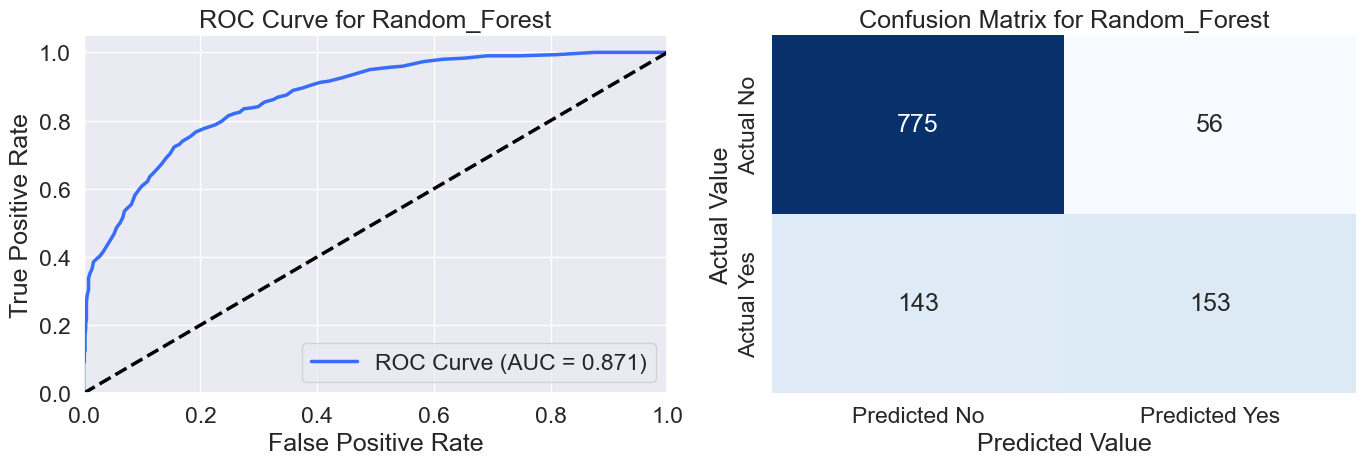

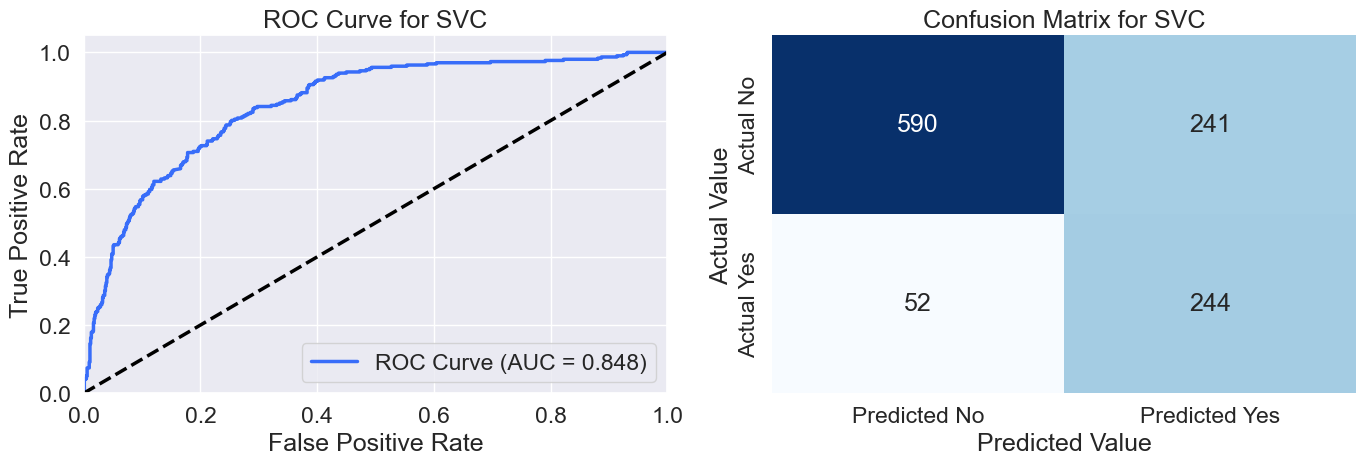

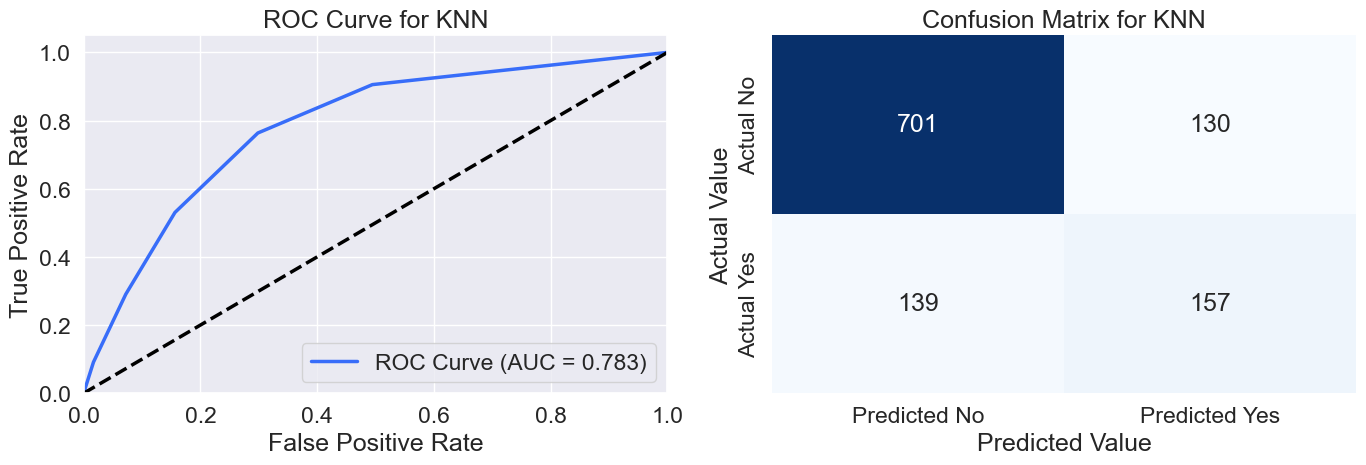

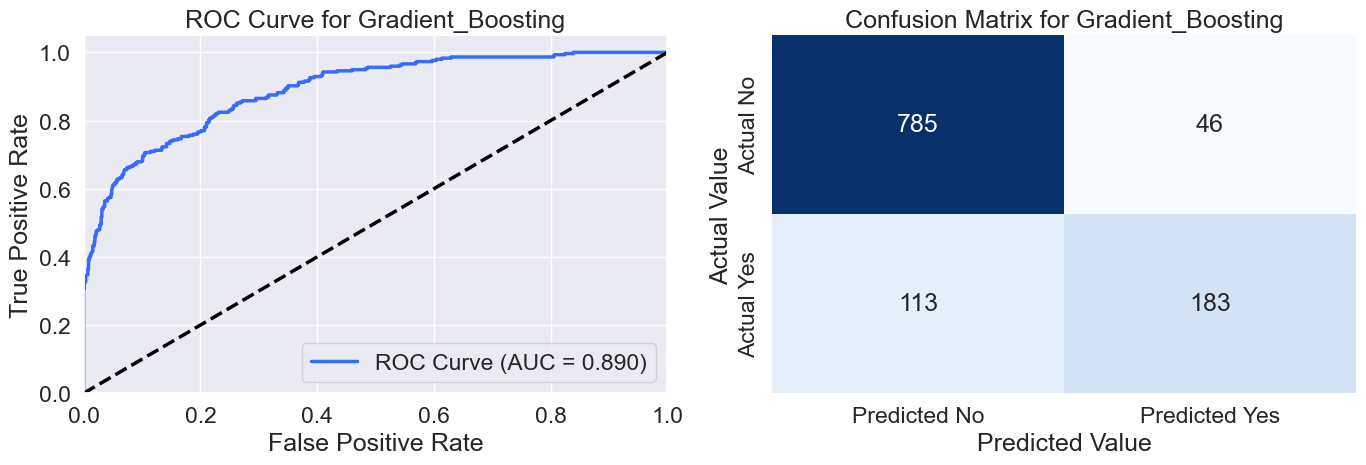

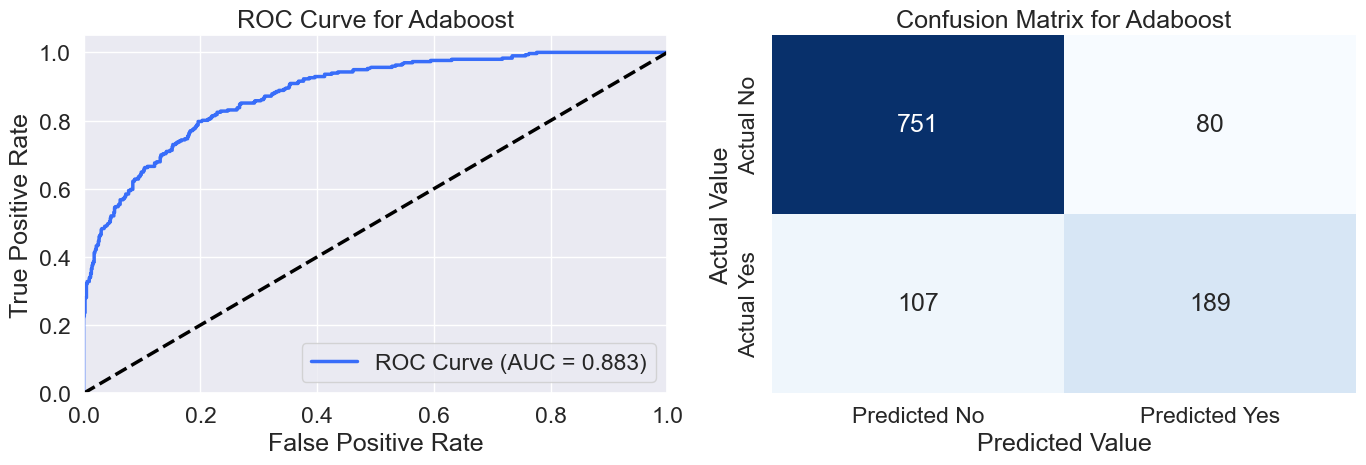

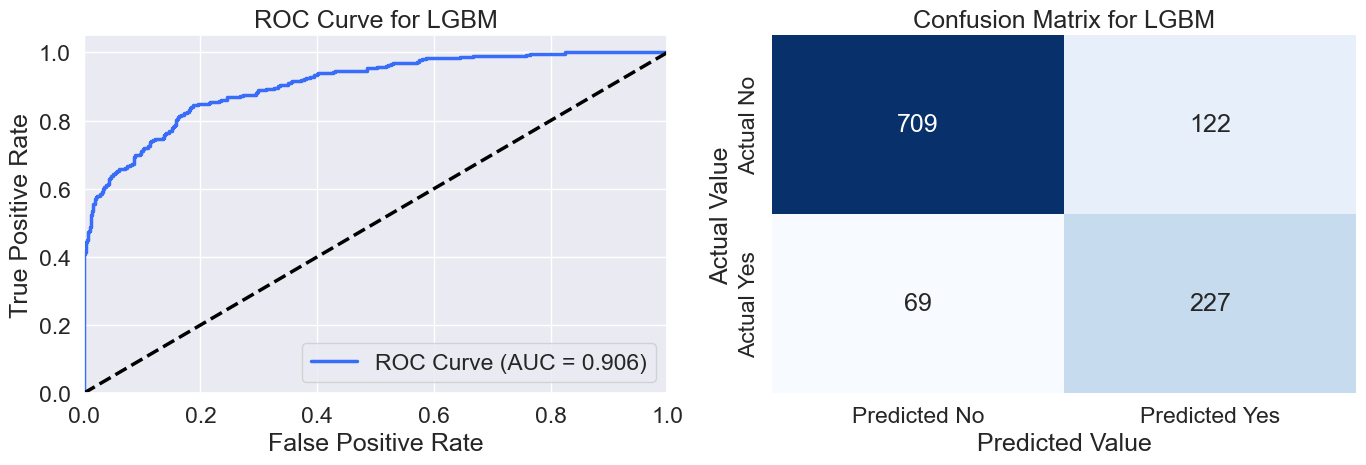

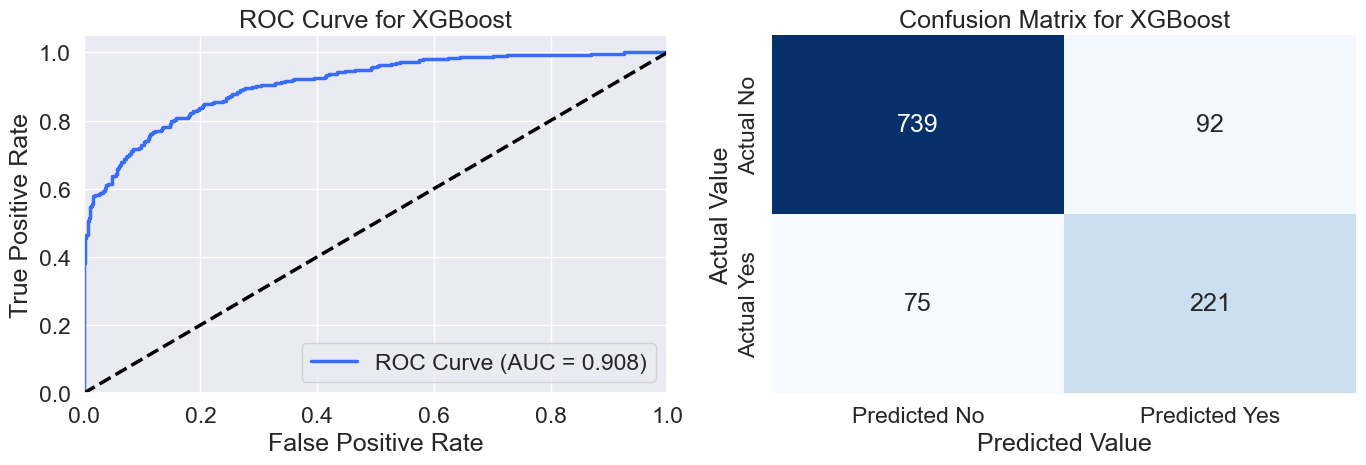

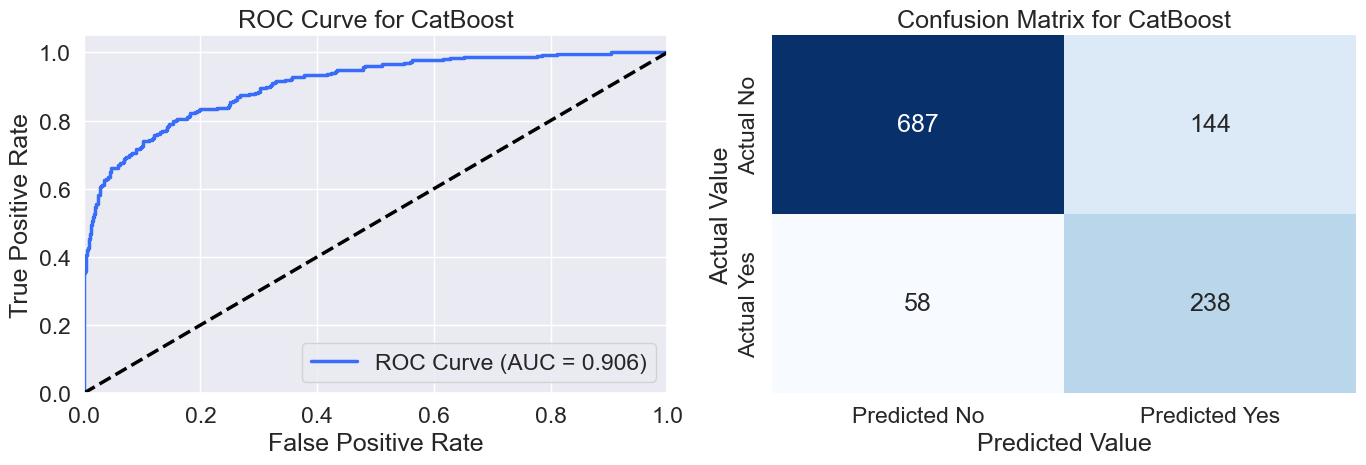

In [160]:
pipelines = {
    'Logistic_Regression': create_pipeline(LogisticRegression(class_weight='balanced', random_state=42), CATEGORICAL_FEATURES),
    'Decision_Tree': create_pipeline(DecisionTreeClassifier(class_weight='balanced', random_state=42), CATEGORICAL_FEATURES),
    'Random_Forest': create_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42), CATEGORICAL_FEATURES),
    'SVC': create_pipeline(SVC(probability=True, class_weight='balanced', random_state=42), CATEGORICAL_FEATURES),
    'KNN': create_pipeline(KNeighborsClassifier(), CATEGORICAL_FEATURES),
    'Gradient_Boosting': create_pipeline(GradientBoostingClassifier(random_state=42), CATEGORICAL_FEATURES),
    'Adaboost': create_pipeline(AdaBoostClassifier(random_state=42), CATEGORICAL_FEATURES),
    'LGBM': create_pipeline(LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1), CATEGORICAL_FEATURES),
    'XGBoost': create_pipeline(XGBClassifier(scale_pos_weight=pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss'), CATEGORICAL_FEATURES),
    'CatBoost': create_pipeline(CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=0), CATEGORICAL_FEATURES)
}

results = {}
for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    results[name] = cv_scores
    pipeline.fit(X_train, y_train)

    if hasattr(pipeline, 'predict_proba'):
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    else:
        try:
            y_pred_proba = pipeline.decision_function(X_val)
        except AttributeError:
            y_pred_proba = pipeline.predict(X_val)

    y_pred = pipeline.predict(X_val)
    auc_roc = roc_auc_score(y_val, y_pred_proba)

    print(f'Model: {name}')
    print(f'AUC-ROC (Cross-Validation): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')
    print(f'AUC-ROC (Validation Set): {auc_roc:.3f}')
    print('\n')
    
    plot_roc_cm(name, y_val, y_pred_proba, y_pred)

We will continue with the 3 best models.

Modelo: LightGBM
AUC-ROC (Cross-Validation): 0.897 ± 0.009 /
AUC-ROC (Validation Set): 0.906


Modelo: XGBoost
AUC-ROC (Cross-Validation): 0.899 ± 0.010 /
AUC-ROC (Validation Set): 0.908


Modelo: CatBoost
AUC-ROC (Cross-Validation): 0.897 ± 0.011 /
AUC-ROC (Validation Set): 0.906

### Hyperparameter Tuning

LightGBM

In [161]:
def objective_lgb(trial):
    params = {
        'objective': 'binary', 
        'metric': 'auc', 
        'boosting_type': 'gbdt', 
        'max_depth': trial.suggest_int('max_depth', 1, 10), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1), 
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200), 
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0), 
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0), 
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), 
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0), 
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), 
    }

    model = LGBMClassifier(**params, verbose=-1)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_pred_proba)
    return roc

In [162]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=100)

In [163]:
print("Best trial:")
trial = study.best_trial

print("  AUC-ROC:", trial.value)
print("  Best hyperparameters: ", trial.params)

Best trial:
  AUC-ROC: 0.9118897778645071
  Best hyperparameters:  {'max_depth': 9, 'learning_rate': 0.08718747214883239, 'num_leaves': 56, 'min_data_in_leaf': 43, 'lambda_l1': 7.874311209252988e-06, 'lambda_l2': 3.2374891319910334e-08, 'bagging_freq': 1, 'bagging_fraction': 0.8341817438761414, 'feature_fraction': 0.8560827508101496}


XGBoost

In [164]:
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic', 
        'eval_metric': 'auc', 
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']), 
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), 
        'max_depth': trial.suggest_int('max_depth', 1, 10), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1), 
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0), 
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0), 
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0), 
    }

    model = XGBClassifier(**params, use_label_encoder=False)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_pred_proba)
    return roc

In [165]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=50)

In [166]:
print("Best trial:")
trial = study.best_trial

print("  AUC-ROC:", trial.value)
print("  Best hyperparameters: ", trial.params)

Best trial:
  AUC-ROC: 0.9219314079422383
  Best hyperparameters:  {'booster': 'dart', 'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.05794227170645261, 'alpha': 0.03876492688956514, 'gamma': 0.00026792115237263953, 'min_child_weight': 1, 'colsample_bytree': 0.9255426022160452, 'subsample': 0.8963462844433424}


CatBoost

In [167]:
def objective_cboost(trial):
    params = {
        'objective': 'Logloss', 
        'eval_metric': 'AUC', 
        'iterations': trial.suggest_int('iterations', 100, 500), 
        'depth': trial.suggest_int('depth', 1, 10), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1), 
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0), 
        'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0), 
        'border_count': trial.suggest_int('border_count', 32, 255), 
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50), 
    } 

    if params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_uniform('subsample', 0.4, 1.0)

    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_pred_proba)
    return roc

In [168]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_cboost, n_trials=100)

In [169]:
print("Best trial:")
trial = study.best_trial

print("  AUC-ROC:", trial.value)
print("  Best hyperparameters: ", trial.params)

Best trial:
  AUC-ROC: 0.9314120076755454
  Best hyperparameters:  {'iterations': 499, 'depth': 5, 'learning_rate': 0.08353440085158355, 'l2_leaf_reg': 0.1452413265141416, 'random_strength': 4.5736470470737704e-06, 'border_count': 178, 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 21}


### Testing Models

LightGBM

In [170]:
model = LGBMClassifier(objective='binary', metric='auc', max_depth=9, learning_rate=0.09897669664239904, num_leaves= 241, min_data_in_leaf=80, lambda_l1=3.7294583699427974e-08, 
                       lambda_l2=3.018954810927601e-08, bagging_freq=4, bagging_fraction=0.9099853567247176, feature_fraction=0.8566017162911089, verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [171]:
roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC for LightGBM: {roc}')

AUC-ROC for LightGBM: 0.9107432888169432


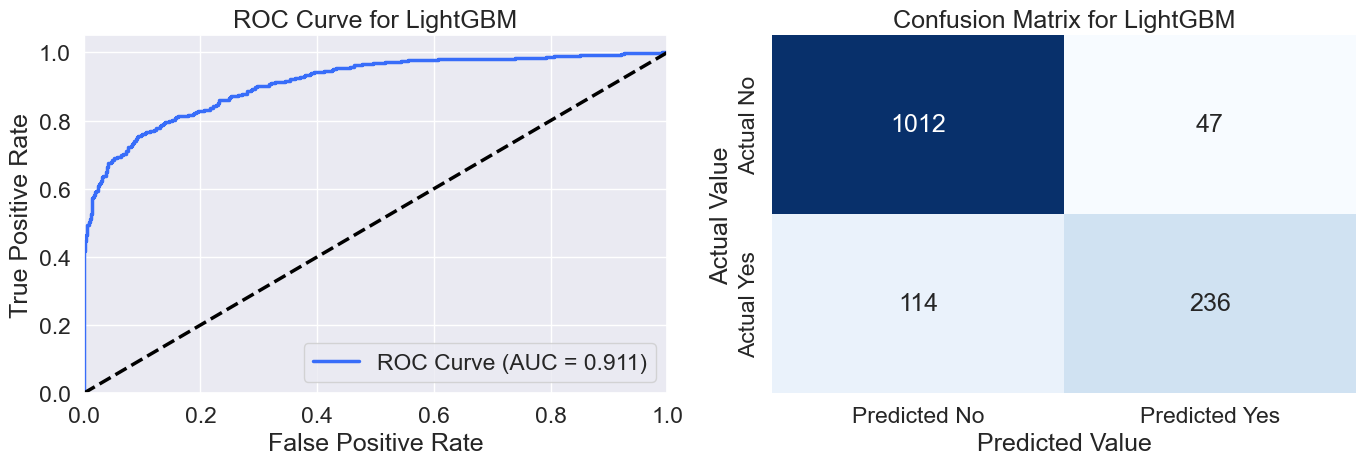

In [172]:
plot_roc_cm('LightGBM', y_test, y_pred_proba, y_pred)

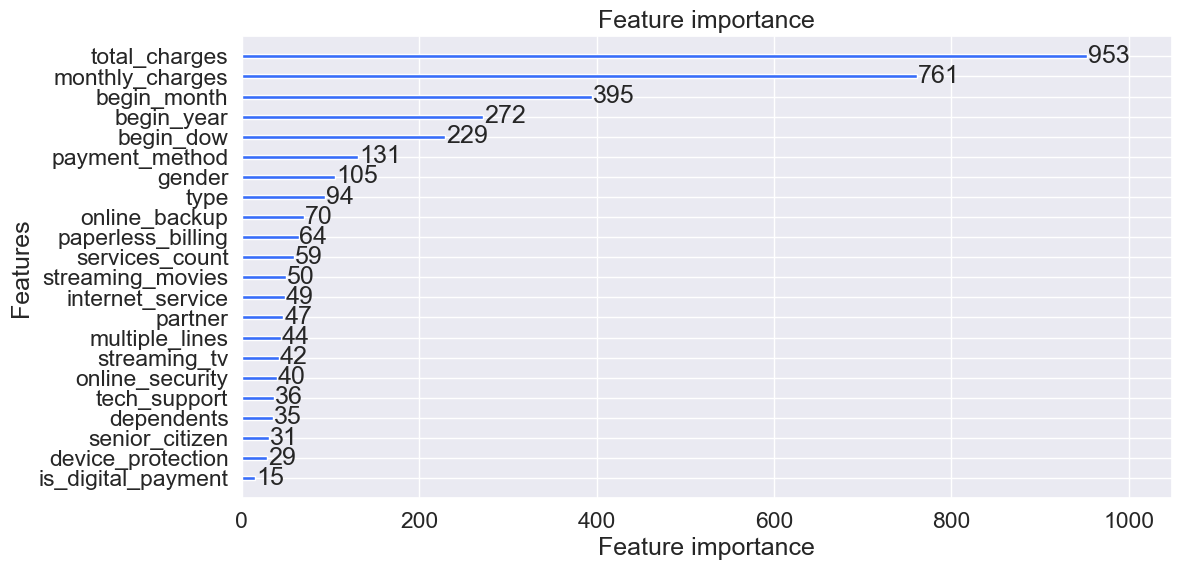

In [173]:
fig, ax = plt.subplots(figsize=(12, 6))
lgb.plot_importance(model, ax=ax);

XGBoost

In [174]:
model = XGBClassifier(objective='binary:logistic', eval_metric='auc', booster='dart', n_estimators=475, max_depth=10, learning_rate=0.06433379729680751, alpha=1.1078394406779828e-05, 
                      gamma=0.1650537350948123, min_child_weight=9, colsample_bytree=0.9360933971267896, sumsample=0.8160154241590846)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [175]:
roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC for XGBoost: {roc}')

AUC-ROC for XGBoost: 0.9190853905301497


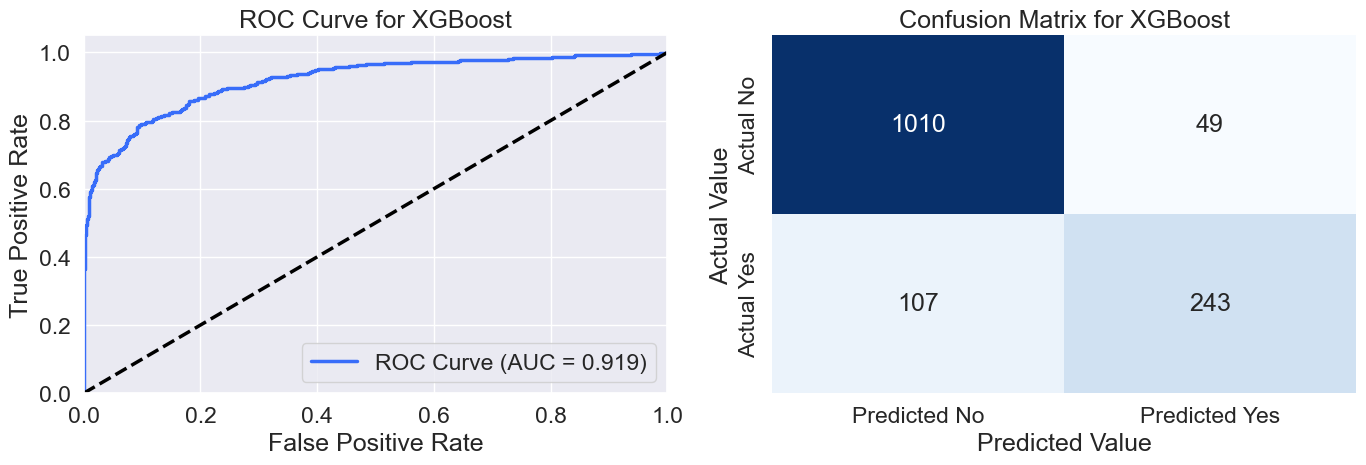

In [176]:
plot_roc_cm('XGBoost', y_test, y_pred_proba, y_pred)

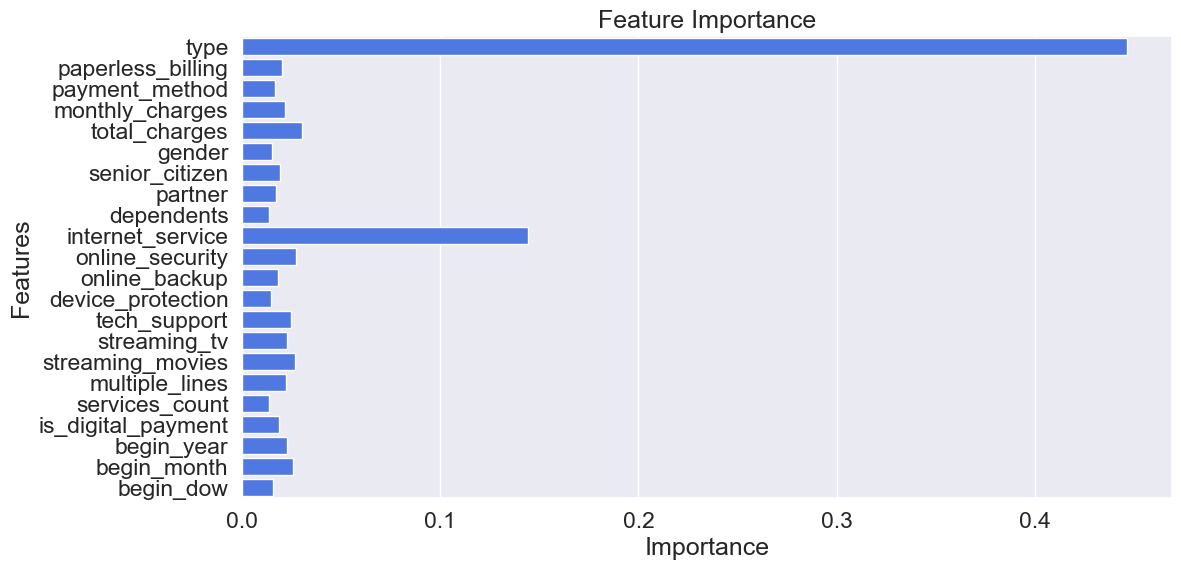

In [177]:
feature_importance = model.feature_importances_
features_names = df[FEATURES].columns

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=feature_importance, y=features_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features');

CatBoost

In [178]:
model = CatBoostClassifier(objective='Logloss', eval_metric='AUC', iterations=448, depth=5, learning_rate=0.07120969578173066, l2_leaf_reg=3.6664036286246935, random_strength=0.003013898378398893, 
                           border_count=126, bootstrap_type='MVS', od_type='IncToDec', od_wait=13, verbose=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

0:	total: 3.91ms	remaining: 1.75s
100:	total: 198ms	remaining: 681ms
200:	total: 458ms	remaining: 562ms
300:	total: 727ms	remaining: 355ms
400:	total: 949ms	remaining: 111ms
447:	total: 1.04s	remaining: 0us


In [179]:
roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC for CatBoost: {roc}')

AUC-ROC for CatBoost: 0.9224308646971536


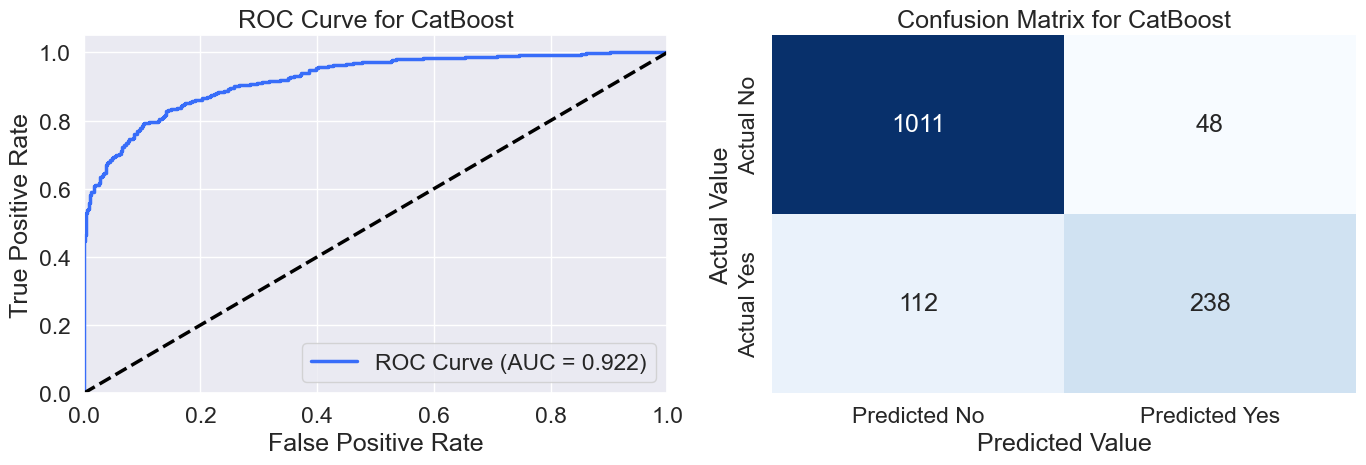

In [180]:
plot_roc_cm('CatBoost', y_test, y_pred_proba, y_pred)

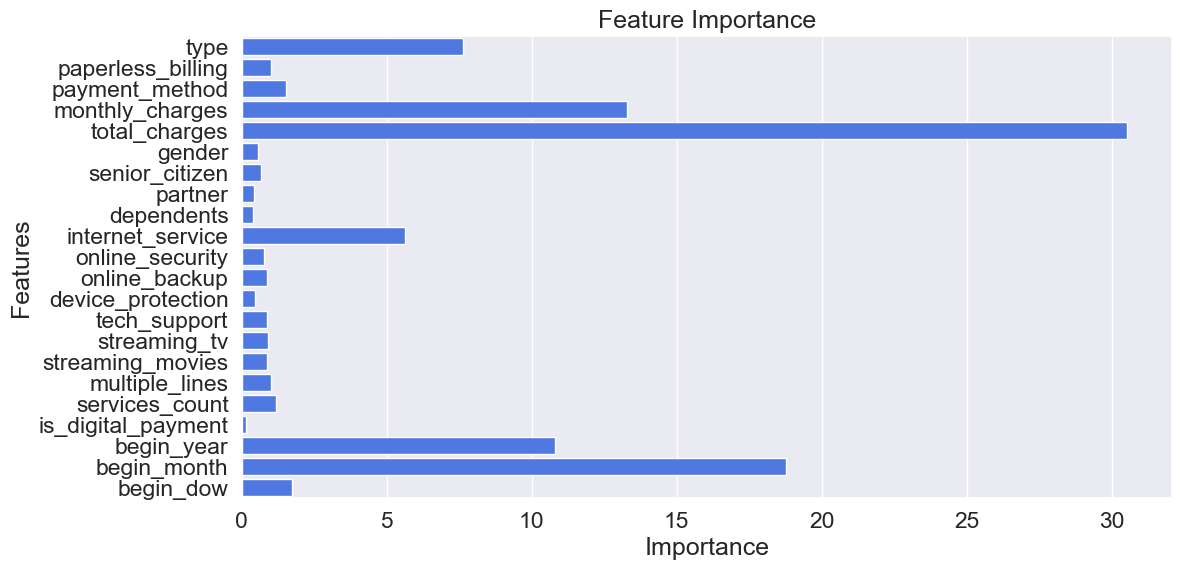

In [181]:
feature_importance = model.get_feature_importance()
features_names = df[FEATURES].columns

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=feature_importance, y=features_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features');

### Model Evaluation

We trained 3 models with excellent AUC-ROC scores. As the final model, we will use CatBoost. In addition to having the highest AUC-ROC score among the 3, it is the model with the greatest variety of features that impact training, an indication that the model is learning to interact with the variables in a more complex and robust way. If we obtain more and more data, this model would continue to be the best option.

### Shap

In [182]:
import shap

In [183]:
model = CatBoostClassifier(objective='Logloss', eval_metric='AUC', iterations=448, depth=5, learning_rate=0.07120969578173066, l2_leaf_reg=3.6664036286246935, random_strength=0.003013898378398893, 
                           border_count=126, bootstrap_type='MVS', od_type='IncToDec', od_wait=13, logging_level='Silent')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

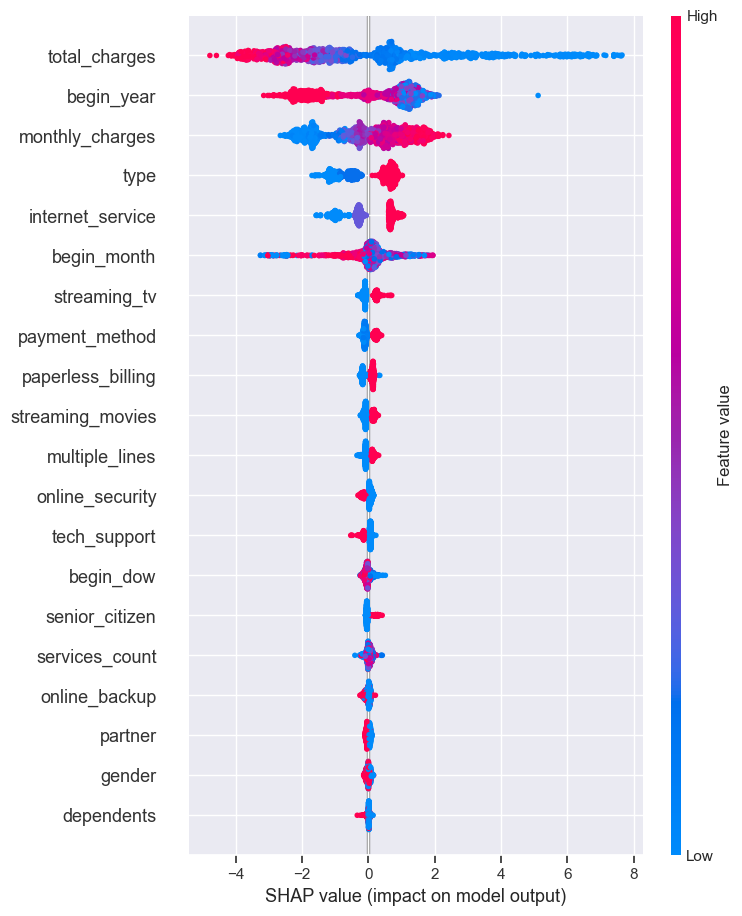

In [184]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Bootstrapping

In [185]:
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    X_resampled, y_resampled = resample(X_train, y_train)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

auc_scores = np.array(auc_scores)
lower = np.percentile(auc_scores, 2.5)
upper = np.percentile(auc_scores, 97.5)

print(f'Confidence interval for AUC: [{lower}, {upper}]')

Confidence interval for AUC: [0.9017864562255496, 0.9167996087953595]


Great model confidence interval.

### Hits and Misses by Feature

In [186]:
y_pred = model.predict(X_test)
X_test['prediction'] = y_pred
X_test['real_value'] = y_test

hits = X_test[X_test['prediction'] == X_test['real_value']]
errors = X_test[X_test['prediction'] != X_test['real_value']]

print("Analysis of hits:")
for feature in X_test.columns:
    if feature in ['begin_month', 'begin_year', 'begin_dow', 'type', 'internet_service', 'payment_method']:
        print(f'Hits by: {feature}')
        print(hits.groupby(feature).size())
        print()

print("Analysis of errors:")
for feature in X_test.columns:
    if feature in ['begin_month', 'begin_year', 'begin_dow', 'type', 'internet_service', 'payment_method']:
        print(f'Erros by: {feature}')
        print(errors.groupby(feature).size())
        print()

Analysis of hits:
Hits by: type
type
0.034320    336
0.108684    261
0.436678    625
dtype: int64

Hits by: payment_method
payment_method
0.159492    292
0.185631    264
0.194932    281
0.451600    385
dtype: int64

Hits by: internet_service
internet_service
0.083271    292
0.189975    437
0.429433    493
dtype: int64

Hits by: begin_year
begin_year
2014    260
2015    158
2016    124
2017    136
2018    153
2019    351
2020     40
dtype: int64

Hits by: begin_month
begin_month
1      96
2     144
3     119
4      87
5      84
6      95
7      97
8      88
9      97
10     94
11    112
12    109
dtype: int64

Hits by: begin_dow
begin_dow
0    138
1    174
2    147
3    134
4    197
5    229
6    203
dtype: int64

Analysis of errors:
Erros by: type
type
0.034320      5
0.108684     42
0.436678    140
dtype: int64

Erros by: payment_method
payment_method
0.159492    34
0.185631    31
0.194932    29
0.451600    93
dtype: int64

Erros by: internet_service
internet_service
0.083271     12
0

### Final Report

We performed the entire step-by-step process for training the model. All inconveniences found were easily resolved during EDA, such as column conversion, creation of the target "churn" column as binary, encoding and scaling performed before training the tested models. With two main stages of the project, one of them being EDA, where we were able to understand the data and analyze possible causes for this problem, and hyperparameter tuning, where we ensured that the model obtained a high AUC score in the test set, as well as in the validation set to solve the problem we identified.

### Final Model - CatBoost

CatBoostClassifier(objective='Logloss', eval_metric='AUC', iterations=448, depth=5, learning_rate=0.07120969578173066, l2_leaf_reg=3.6664036286246935, random_strength=0.003013898378398893, border_count=126, bootstrap_type='MVS', od_type='IncToDec', od_wait=13)

AUC-ROC for CatBoost: 0.9224308646971536